# Image Multimodal Search

This notebooks shows how to carry out an image multimodal search with the [LAVIS](https://github.com/salesforce/LAVIS) library. 

The first cell is only run on google colab and installs the [ammico](https://github.com/ssciwr/AMMICO) package.

After that, we can import `ammico` and read in the files given a folder path.

In [1]:
# if running on google colab
# flake8-noqa-cell
import os

if "google.colab" in str(get_ipython()):
    # update python version
    # install setuptools
    # %pip install setuptools==61 -qqq
    # install ammico
    %pip install git+https://github.com/ssciwr/ammico.git -qqq
    # mount google drive for data and API key
    from google.colab import drive

    drive.mount("/content/drive")

In [2]:
import ammico.utils as mutils
import ammico.multimodal_search as ms

In [3]:
images = mutils.find_files(
    path="data/",
    limit=10,
)

In [4]:
images

['data/102730_eng.png', 'data/106349S_por.png', 'data/102141_2_eng.png']

In [5]:
mydict = mutils.initialize_dict(images)

In [6]:
mydict

{'102730_eng': {'filename': 'data/102730_eng.png'},
 '106349S_por': {'filename': 'data/106349S_por.png'},
 '102141_2_eng': {'filename': 'data/102141_2_eng.png'}}

## Indexing and extracting features from images in selected folder

First you need to select a model. You can choose one of the following models: 
- [blip](https://github.com/salesforce/BLIP)
- [blip2](https://huggingface.co/docs/transformers/main/model_doc/blip-2) 
- [albef](https://github.com/salesforce/ALBEF) 
- [clip_base](https://github.com/openai/CLIP/blob/main/model-card.md)
- [clip_vitl14](https://github.com/mlfoundations/open_clip) 
- [clip_vitl14_336](https://github.com/mlfoundations/open_clip)

In [7]:
model_type = "blip"
# model_type = "blip2"
# model_type = "albef"
# model_type = "clip_base"
# model_type = "clip_vitl14"
# model_type = "clip_vitl14_336"

To process the loaded images using the selected model, use the below code:

In [8]:
my_obj = ms.MultimodalSearch(mydict)

In [9]:
my_obj.subdict

{'102730_eng': {'filename': 'data/102730_eng.png'},
 '106349S_por': {'filename': 'data/106349S_por.png'},
 '102141_2_eng': {'filename': 'data/102141_2_eng.png'}}

In [10]:
(
    model,
    vis_processors,
    txt_processors,
    image_keys,
    image_names,
    features_image_stacked,
) = my_obj.parsing_images(
    model_type, 
    path_to_save_tensors="data/",
    )

  0%|          | 0.00/1.97G [00:00<?, ?B/s]

  1%|          | 10.1M/1.97G [00:00<00:19, 106MB/s]

  1%|▏         | 27.4M/1.97G [00:00<00:13, 150MB/s]

  2%|▏         | 49.8M/1.97G [00:00<00:10, 189MB/s]

  4%|▎         | 72.3M/1.97G [00:00<00:09, 207MB/s]

  5%|▍         | 94.6M/1.97G [00:00<00:09, 217MB/s]

  6%|▌         | 116M/1.97G [00:00<00:09, 221MB/s] 

  7%|▋         | 138M/1.97G [00:00<00:09, 216MB/s]

  8%|▊         | 161M/1.97G [00:00<00:08, 225MB/s]

  9%|▉         | 182M/1.97G [00:00<00:09, 195MB/s]

 10%|▉         | 202M/1.97G [00:01<00:10, 179MB/s]

 11%|█         | 219M/1.97G [00:01<00:10, 178MB/s]

 12%|█▏        | 238M/1.97G [00:01<00:10, 182MB/s]

 13%|█▎        | 255M/1.97G [00:01<00:10, 178MB/s]

 14%|█▎        | 273M/1.97G [00:01<00:10, 178MB/s]

 14%|█▍        | 290M/1.97G [00:01<00:10, 181MB/s]

 15%|█▌        | 308M/1.97G [00:01<00:09, 182MB/s]

 16%|█▌        | 326M/1.97G [00:01<00:09, 184MB/s]

 17%|█▋        | 345M/1.97G [00:01<00:09, 189MB/s]

 18%|█▊        | 365M/1.97G [00:02<00:08, 193MB/s]

 19%|█▉        | 383M/1.97G [00:02<00:08, 191MB/s]

 20%|█▉        | 402M/1.97G [00:02<00:08, 192MB/s]

 21%|██        | 421M/1.97G [00:02<00:08, 194MB/s]

 22%|██▏       | 439M/1.97G [00:02<00:08, 193MB/s]

 23%|██▎       | 457M/1.97G [00:02<00:08, 187MB/s]

 24%|██▎       | 475M/1.97G [00:02<00:08, 188MB/s]

 24%|██▍       | 494M/1.97G [00:02<00:08, 189MB/s]

 25%|██▌       | 512M/1.97G [00:02<00:08, 182MB/s]

 26%|██▌       | 530M/1.97G [00:02<00:08, 184MB/s]

 27%|██▋       | 548M/1.97G [00:03<00:08, 185MB/s]

 28%|██▊       | 565M/1.97G [00:03<00:08, 180MB/s]

 29%|██▉       | 584M/1.97G [00:03<00:08, 183MB/s]

 30%|██▉       | 601M/1.97G [00:03<00:08, 184MB/s]

 31%|███       | 619M/1.97G [00:03<00:08, 180MB/s]

 32%|███▏      | 636M/1.97G [00:03<00:08, 177MB/s]

 32%|███▏      | 653M/1.97G [00:03<00:08, 177MB/s]

 33%|███▎      | 670M/1.97G [00:03<00:08, 175MB/s]

 34%|███▍      | 686M/1.97G [00:03<00:08, 173MB/s]

 35%|███▍      | 703M/1.97G [00:03<00:08, 172MB/s]

 36%|███▌      | 720M/1.97G [00:04<00:07, 174MB/s]

 37%|███▋      | 737M/1.97G [00:04<00:07, 175MB/s]

 37%|███▋      | 754M/1.97G [00:04<00:07, 167MB/s]

 38%|███▊      | 770M/1.97G [00:04<00:07, 168MB/s]

 39%|███▉      | 786M/1.97G [00:04<00:07, 170MB/s]

 40%|███▉      | 803M/1.97G [00:04<00:07, 160MB/s]

 41%|████      | 818M/1.97G [00:04<00:07, 161MB/s]

 41%|████▏     | 837M/1.97G [00:04<00:07, 170MB/s]

 42%|████▏     | 853M/1.97G [00:04<00:07, 171MB/s]

 43%|████▎     | 870M/1.97G [00:05<00:08, 138MB/s]

 44%|████▍     | 889M/1.97G [00:05<00:07, 153MB/s]

 45%|████▍     | 904M/1.97G [00:05<00:07, 154MB/s]

 46%|████▌     | 922M/1.97G [00:05<00:07, 163MB/s]

 47%|████▋     | 940M/1.97G [00:05<00:06, 170MB/s]

 47%|████▋     | 957M/1.97G [00:05<00:06, 168MB/s]

 48%|████▊     | 975M/1.97G [00:05<00:06, 173MB/s]

 49%|████▉     | 991M/1.97G [00:05<00:06, 173MB/s]

 50%|████▉     | 0.98G/1.97G [00:05<00:06, 172MB/s]

 51%|█████     | 1.00G/1.97G [00:06<00:06, 172MB/s]

 52%|█████▏    | 1.02G/1.97G [00:06<00:05, 176MB/s]

 52%|█████▏    | 1.03G/1.97G [00:06<00:05, 175MB/s]

 53%|█████▎    | 1.05G/1.97G [00:06<00:05, 176MB/s]

 54%|█████▍    | 1.07G/1.97G [00:06<00:05, 180MB/s]

 55%|█████▌    | 1.09G/1.97G [00:06<00:05, 180MB/s]

 56%|█████▌    | 1.10G/1.97G [00:06<00:05, 172MB/s]

 57%|█████▋    | 1.12G/1.97G [00:06<00:05, 172MB/s]

 58%|█████▊    | 1.14G/1.97G [00:06<00:05, 176MB/s]

 59%|█████▊    | 1.15G/1.97G [00:06<00:04, 182MB/s]

 59%|█████▉    | 1.17G/1.97G [00:07<00:04, 180MB/s]

 60%|██████    | 1.19G/1.97G [00:07<00:04, 180MB/s]

 61%|██████    | 1.21G/1.97G [00:07<00:04, 187MB/s]

 62%|██████▏   | 1.22G/1.97G [00:07<00:04, 186MB/s]

 63%|██████▎   | 1.24G/1.97G [00:07<00:04, 186MB/s]

 64%|██████▍   | 1.26G/1.97G [00:07<00:04, 185MB/s]

 65%|██████▍   | 1.28G/1.97G [00:07<00:04, 182MB/s]

 66%|██████▌   | 1.29G/1.97G [00:07<00:04, 180MB/s]

 67%|██████▋   | 1.31G/1.97G [00:07<00:03, 182MB/s]

 67%|██████▋   | 1.33G/1.97G [00:07<00:03, 186MB/s]

 68%|██████▊   | 1.35G/1.97G [00:09<00:18, 35.4MB/s]

 69%|██████▉   | 1.36G/1.97G [00:09<00:15, 43.3MB/s]

 70%|██████▉   | 1.38G/1.97G [00:09<00:11, 57.1MB/s]

 71%|███████   | 1.39G/1.97G [00:10<00:22, 28.2MB/s]

 71%|███████   | 1.40G/1.97G [00:11<00:18, 33.1MB/s]

 72%|███████▏  | 1.41G/1.97G [00:11<00:14, 41.1MB/s]

 72%|███████▏  | 1.42G/1.97G [00:11<00:12, 48.1MB/s]

 73%|███████▎  | 1.44G/1.97G [00:11<00:09, 61.2MB/s]

 73%|███████▎  | 1.45G/1.97G [00:11<00:08, 69.1MB/s]

 74%|███████▍  | 1.46G/1.97G [00:11<00:06, 81.2MB/s]

 75%|███████▍  | 1.47G/1.97G [00:11<00:05, 94.0MB/s]

 76%|███████▌  | 1.49G/1.97G [00:11<00:04, 106MB/s] 

 76%|███████▋  | 1.51G/1.97G [00:11<00:03, 129MB/s]

 77%|███████▋  | 1.53G/1.97G [00:12<00:03, 151MB/s]

 78%|███████▊  | 1.54G/1.97G [00:12<00:03, 134MB/s]

 79%|███████▉  | 1.56G/1.97G [00:12<00:02, 150MB/s]

 80%|████████  | 1.58G/1.97G [00:12<00:02, 163MB/s]

 81%|████████  | 1.60G/1.97G [00:13<00:09, 41.6MB/s]

 82%|████████▏ | 1.61G/1.97G [00:13<00:07, 49.1MB/s]

 82%|████████▏ | 1.62G/1.97G [00:13<00:07, 51.9MB/s]

 83%|████████▎ | 1.63G/1.97G [00:14<00:05, 60.7MB/s]

 84%|████████▎ | 1.65G/1.97G [00:14<00:04, 79.3MB/s]

 84%|████████▍ | 1.66G/1.97G [00:14<00:03, 87.6MB/s]

 85%|████████▍ | 1.67G/1.97G [00:14<00:03, 92.8MB/s]

 86%|████████▌ | 1.69G/1.97G [00:14<00:02, 112MB/s] 

 87%|████████▋ | 1.71G/1.97G [00:14<00:02, 129MB/s]

 87%|████████▋ | 1.72G/1.97G [00:14<00:01, 137MB/s]

 88%|████████▊ | 1.74G/1.97G [00:14<00:01, 148MB/s]

 89%|████████▉ | 1.76G/1.97G [00:15<00:03, 59.5MB/s]

 90%|████████▉ | 1.77G/1.97G [00:15<00:02, 72.0MB/s]

 90%|█████████ | 1.78G/1.97G [00:15<00:02, 75.7MB/s]

 91%|█████████▏| 1.80G/1.97G [00:15<00:02, 92.4MB/s]

 92%|█████████▏| 1.81G/1.97G [00:15<00:01, 105MB/s] 

 93%|█████████▎| 1.83G/1.97G [00:15<00:01, 124MB/s]

 94%|█████████▍| 1.85G/1.97G [00:16<00:00, 142MB/s]

 95%|█████████▍| 1.87G/1.97G [00:16<00:00, 153MB/s]

 96%|█████████▌| 1.88G/1.97G [00:16<00:00, 161MB/s]

 96%|█████████▋| 1.90G/1.97G [00:16<00:00, 168MB/s]

 97%|█████████▋| 1.92G/1.97G [00:16<00:00, 172MB/s]

 98%|█████████▊| 1.94G/1.97G [00:16<00:00, 177MB/s]

 99%|█████████▉| 1.95G/1.97G [00:16<00:00, 180MB/s]

100%|██████████| 1.97G/1.97G [00:16<00:00, 126MB/s]

In [11]:
features_image_stacked

tensor([[ 1.1012e-01, -7.5168e-02,  5.1168e-02, -1.7778e-01, -1.6888e-01,
         -9.1131e-04,  1.3566e-02, -1.4314e-01,  6.6218e-02, -4.5880e-02,
          1.4472e-02,  4.8086e-02,  6.6030e-03,  4.4415e-02,  5.3860e-03,
          4.4499e-02, -3.1550e-02,  1.0571e-02, -5.8567e-02,  3.1155e-02,
          5.4091e-02, -1.0610e-01, -2.5944e-02, -7.5799e-03,  6.8304e-02,
         -6.6986e-02,  8.0149e-02, -1.2928e-02, -6.3677e-02, -5.2397e-02,
         -1.3488e-01, -8.1277e-02,  1.1877e-03, -5.3062e-02,  7.8236e-02,
          5.2935e-02,  3.3612e-03, -6.9611e-02, -3.2997e-02,  5.7090e-02,
         -8.5948e-02, -9.3056e-02,  5.7117e-02, -1.2415e-01, -5.9904e-02,
         -5.9758e-02, -1.3205e-01, -7.9004e-02, -2.5256e-02, -1.0186e-01,
          6.6683e-02,  3.1179e-02, -8.6700e-02, -2.4749e-02,  5.9429e-02,
          5.7969e-02,  4.3389e-02,  1.4305e-02,  4.1522e-02,  4.5499e-02,
          5.9856e-02,  5.0948e-02, -9.5958e-02,  5.9539e-04,  6.9768e-02,
          4.8947e-02,  5.3179e-02,  3.

The images are then processed and stored in a numerical representation, a tensor. These tensors do not change for the same image and same model - so if you run this analysis once, and save the tensors giving a path with the keyword `path_to_save_tensors`, a file with filename `.<Number_of_images>_<model_name>_saved_features_image.pt` will be placed there.

This will save you a lot of time if you want to analyse same images with the same model but different questions. To run using the saved tensors, execute the below code giving the path and name of the tensor file.

In [12]:
# (
#     model,
#     vis_processors,
#     txt_processors,
#     image_keys,
#     image_names,
#     features_image_stacked,
# ) = my_obj.parsing_images(
#     model_type,
#     path_to_load_tensors="/content/drive/MyDrive/misinformation-data/5_clip_base_saved_features_image.pt",
# )

Here we already processed our image folder with 5 images and the `clip_base` model. So you need just to write the name `5_clip_base_saved_features_image.pt` of the saved file that consists of tensors of all images as keyword argument for `path_to_load_tensors`. 

## Formulate your search queries

Next, you need to form search queries. You can search either by image or by text. You can search for a single query, or you can search for several queries at once, the computational time should not be much different. The format of the queries is as follows:

In [13]:
search_query3 = [
    {"text_input": "politician press conference"},
    {"text_input": "a world map"},
    {"text_input": "a dog"},
]

You can filter your results in 3 different ways:
- `filter_number_of_images` limits the number of images found. That is, if the parameter `filter_number_of_images = 10`, then the first 10 images that best match the query will be shown. The other images ranks will be set to `None` and the similarity value to `0`.
- `filter_val_limit` limits the output of images with a similarity value not bigger than `filter_val_limit`. That is, if the parameter `filter_val_limit = 0.2`, all images with similarity less than 0.2 will be discarded.
- `filter_rel_error` (percentage) limits the output of images with a similarity value not bigger than `100 * abs(current_simularity_value - best_simularity_value_in_current_search)/best_simularity_value_in_current_search < filter_rel_error`. That is, if we set filter_rel_error = 30, it means that if the top1 image have 0.5 similarity value, we discard all image with similarity less than 0.35.

In [14]:
similarity, sorted_lists = my_obj.multimodal_search(
    model,
    vis_processors,
    txt_processors,
    model_type,
    image_keys,
    features_image_stacked,
    search_query3,
    filter_number_of_images=20,
)

In [15]:
similarity

tensor([[0.1135, 0.1063, 0.0490],
        [0.1441, 0.1311, 0.1008],
        [0.1666, 0.0935, 0.1086]])

In [16]:
sorted_lists

[[2, 1, 0], [1, 0, 2], [2, 1, 0]]

In [17]:
mydict

{'102730_eng': {'filename': 'data/102730_eng.png',
  'rank politician press conference': 1,
  'politician press conference': 0.14405080676078796,
  'rank a world map': 0,
  'a world map': 0.13108758628368378,
  'rank a dog': 1,
  'a dog': 0.10083306580781937},
 '106349S_por': {'filename': 'data/106349S_por.png',
  'rank politician press conference': 0,
  'politician press conference': 0.16655391454696655,
  'rank a world map': 2,
  'a world map': 0.0935291051864624,
  'rank a dog': 0,
  'a dog': 0.1086294949054718},
 '102141_2_eng': {'filename': 'data/102141_2_eng.png',
  'rank politician press conference': 2,
  'politician press conference': 0.11350081115961075,
  'rank a world map': 1,
  'a world map': 0.1063341423869133,
  'rank a dog': 2,
  'a dog': 0.04904010146856308}}

After launching `multimodal_search` function, the results of each query will be added to the source dictionary.  

In [18]:
mydict["106349S_por"]

{'filename': 'data/106349S_por.png',
 'rank politician press conference': 0,
 'politician press conference': 0.16655391454696655,
 'rank a world map': 2,
 'a world map': 0.0935291051864624,
 'rank a dog': 0,
 'a dog': 0.1086294949054718}

A special function was written to present the search results conveniently. 

'Your search query: politician press conference'

'--------------------------------------------------'

'Results:'

'Rank: 0 Val: 0.16655391454696655'

'106349S_por'

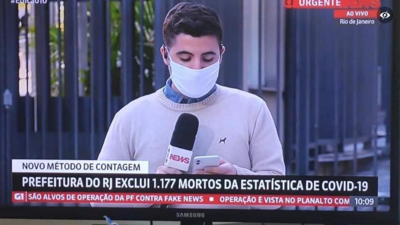

'--------------------------------------------------'

'Rank: 1 Val: 0.14405080676078796'

'102730_eng'

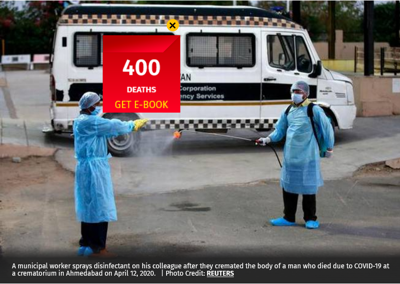

'--------------------------------------------------'

'Rank: 2 Val: 0.11350081115961075'

'102141_2_eng'

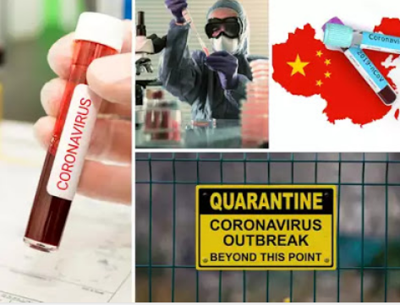

'--------------------------------------------------'

In [19]:
my_obj.show_results(
    search_query3[0],
)

## Improve the search results

For even better results, a slightly different approach has been prepared that can improve search results. It is quite resource-intensive, so it is applied after the main algorithm has found the most relevant images. This approach works only with text queries. Among the parameters you can choose 3 models: `"blip_base"`, `"blip_large"`, `"blip2_coco"`. If you get an `Out of Memory` error, try reducing the batch_size value (minimum = 1), which is the number of images being processed simultaneously. With the parameter `need_grad_cam = True/False` you can enable the calculation of the heat map of each image to be processed. Thus the `image_text_match_reordering` function calculates new similarity values and new ranks for each image. The resulting values are added to the general dictionary.

In [20]:
itm_model = "blip_base"
# itm_model = "blip_large"
# itm_model = "blip2_coco"

In [21]:
itm_scores, image_gradcam_with_itm = my_obj.image_text_match_reordering(
    search_query3,
    itm_model,
    image_keys,
    sorted_lists,
    batch_size=1,
    need_grad_cam=True,
)

  0%|          | 0.00/1.78G [00:00<?, ?B/s]

  1%|          | 9.64M/1.78G [00:00<00:18, 101MB/s]

  1%|▏         | 24.4M/1.78G [00:00<00:14, 133MB/s]

  2%|▏         | 44.0M/1.78G [00:00<00:11, 166MB/s]

  3%|▎         | 61.5M/1.78G [00:00<00:10, 173MB/s]

  4%|▍         | 80.1M/1.78G [00:00<00:10, 181MB/s]

  5%|▌         | 97.4M/1.78G [00:00<00:10, 178MB/s]

  6%|▋         | 114M/1.78G [00:00<00:10, 179MB/s] 

  7%|▋         | 134M/1.78G [00:00<00:09, 187MB/s]

  8%|▊         | 155M/1.78G [00:00<00:08, 196MB/s]

 10%|▉         | 173M/1.78G [00:01<00:09, 191MB/s]

 11%|█         | 192M/1.78G [00:01<00:08, 190MB/s]

 12%|█▏        | 212M/1.78G [00:01<00:08, 194MB/s]

 13%|█▎        | 233M/1.78G [00:01<00:08, 204MB/s]

 14%|█▍        | 253M/1.78G [00:01<00:08, 195MB/s]

 15%|█▌        | 274M/1.78G [00:01<00:07, 204MB/s]

 16%|█▋        | 296M/1.78G [00:01<00:07, 212MB/s]

 17%|█▋        | 317M/1.78G [00:01<00:07, 205MB/s]

 18%|█▊        | 336M/1.78G [00:01<00:07, 195MB/s]

 20%|█▉        | 355M/1.78G [00:01<00:08, 182MB/s]

 20%|██        | 373M/1.78G [00:02<00:08, 179MB/s]

 21%|██▏       | 390M/1.78G [00:02<00:09, 164MB/s]

 23%|██▎       | 411M/1.78G [00:02<00:08, 178MB/s]

 24%|██▎       | 428M/1.78G [00:02<00:09, 154MB/s]

 25%|██▍       | 451M/1.78G [00:02<00:08, 176MB/s]

 26%|██▌       | 469M/1.78G [00:02<00:07, 181MB/s]

 27%|██▋       | 488M/1.78G [00:02<00:07, 183MB/s]

 28%|██▊       | 506M/1.78G [00:02<00:09, 146MB/s]

 29%|██▉       | 526M/1.78G [00:03<00:08, 164MB/s]

 30%|███       | 547M/1.78G [00:03<00:07, 177MB/s]

 31%|███       | 567M/1.78G [00:03<00:07, 185MB/s]

 32%|███▏      | 585M/1.78G [00:03<00:15, 86.2MB/s]

 33%|███▎      | 604M/1.78G [00:03<00:12, 104MB/s] 

 34%|███▍      | 625M/1.78G [00:04<00:10, 123MB/s]

 35%|███▌      | 642M/1.78G [00:04<00:09, 132MB/s]

 36%|███▌      | 658M/1.78G [00:04<00:10, 118MB/s]

 37%|███▋      | 672M/1.78G [00:04<00:13, 86.8MB/s]

 38%|███▊      | 687M/1.78G [00:04<00:12, 98.2MB/s]

 39%|███▊      | 702M/1.78G [00:04<00:10, 111MB/s] 

 39%|███▉      | 716M/1.78G [00:04<00:10, 107MB/s]

 40%|████      | 736M/1.78G [00:05<00:13, 84.7MB/s]

 42%|████▏     | 757M/1.78G [00:05<00:10, 107MB/s] 

 42%|████▏     | 770M/1.78G [00:05<00:10, 101MB/s]

 43%|████▎     | 789M/1.78G [00:05<00:08, 121MB/s]

 44%|████▍     | 808M/1.78G [00:05<00:08, 129MB/s]

 45%|████▌     | 824M/1.78G [00:05<00:07, 139MB/s]

 46%|████▋     | 845M/1.78G [00:05<00:06, 159MB/s]

 47%|████▋     | 862M/1.78G [00:06<00:06, 164MB/s]

 48%|████▊     | 879M/1.78G [00:06<00:07, 138MB/s]

 49%|████▉     | 894M/1.78G [00:06<00:07, 139MB/s]

 50%|████▉     | 908M/1.78G [00:06<00:08, 118MB/s]

 51%|█████     | 926M/1.78G [00:06<00:07, 133MB/s]

 52%|█████▏    | 939M/1.78G [00:06<00:07, 124MB/s]

 53%|█████▎    | 960M/1.78G [00:06<00:06, 146MB/s]

 54%|█████▎    | 975M/1.78G [00:07<00:07, 125MB/s]

 54%|█████▍    | 990M/1.78G [00:07<00:06, 134MB/s]

 55%|█████▌    | 0.98G/1.78G [00:07<00:06, 139MB/s]

 56%|█████▌    | 1.00G/1.78G [00:07<00:05, 147MB/s]

 57%|█████▋    | 1.01G/1.78G [00:07<00:05, 156MB/s]

 58%|█████▊    | 1.03G/1.78G [00:07<00:05, 159MB/s]

 59%|█████▊    | 1.04G/1.78G [00:07<00:05, 145MB/s]

 60%|█████▉    | 1.06G/1.78G [00:07<00:04, 160MB/s]

 61%|██████    | 1.08G/1.78G [00:07<00:04, 175MB/s]

 62%|██████▏   | 1.10G/1.78G [00:08<00:03, 183MB/s]

 63%|██████▎   | 1.12G/1.78G [00:08<00:04, 158MB/s]

 64%|██████▍   | 1.14G/1.78G [00:08<00:03, 174MB/s]

 65%|██████▌   | 1.16G/1.78G [00:08<00:03, 171MB/s]

 66%|██████▋   | 1.18G/1.78G [00:08<00:03, 186MB/s]

 67%|██████▋   | 1.20G/1.78G [00:08<00:03, 184MB/s]

 68%|██████▊   | 1.21G/1.78G [00:09<00:10, 57.6MB/s]

 69%|██████▉   | 1.23G/1.78G [00:09<00:10, 57.9MB/s]

 70%|██████▉   | 1.24G/1.78G [00:09<00:09, 60.1MB/s]

 70%|███████   | 1.25G/1.78G [00:09<00:07, 74.4MB/s]

 71%|███████   | 1.26G/1.78G [00:10<00:06, 81.0MB/s]

 72%|███████▏  | 1.27G/1.78G [00:10<00:06, 84.0MB/s]

 73%|███████▎  | 1.29G/1.78G [00:10<00:05, 95.1MB/s]

 73%|███████▎  | 1.30G/1.78G [00:10<00:05, 93.6MB/s]

 74%|███████▍  | 1.31G/1.78G [00:10<00:07, 66.2MB/s]

 75%|███████▌  | 1.33G/1.78G [00:10<00:05, 91.6MB/s]

 76%|███████▌  | 1.35G/1.78G [00:11<00:05, 77.5MB/s]

 77%|███████▋  | 1.37G/1.78G [00:11<00:04, 91.0MB/s]

 78%|███████▊  | 1.38G/1.78G [00:11<00:05, 78.0MB/s]

 78%|███████▊  | 1.39G/1.78G [00:11<00:04, 92.9MB/s]

 79%|███████▉  | 1.41G/1.78G [00:11<00:03, 108MB/s] 

 80%|████████  | 1.42G/1.78G [00:11<00:03, 123MB/s]

 81%|████████  | 1.44G/1.78G [00:11<00:02, 131MB/s]

 82%|████████▏ | 1.45G/1.78G [00:12<00:02, 127MB/s]

 83%|████████▎ | 1.47G/1.78G [00:12<00:02, 141MB/s]

 84%|████████▎ | 1.49G/1.78G [00:12<00:02, 148MB/s]

 85%|████████▍ | 1.50G/1.78G [00:12<00:01, 157MB/s]

 85%|████████▌ | 1.52G/1.78G [00:12<00:01, 161MB/s]

 86%|████████▋ | 1.54G/1.78G [00:12<00:01, 168MB/s]

 87%|████████▋ | 1.55G/1.78G [00:12<00:01, 173MB/s]

 88%|████████▊ | 1.57G/1.78G [00:12<00:01, 172MB/s]

 89%|████████▉ | 1.59G/1.78G [00:12<00:01, 161MB/s]

 90%|█████████ | 1.60G/1.78G [00:13<00:01, 102MB/s]

 91%|█████████ | 1.62G/1.78G [00:13<00:01, 110MB/s]

 92%|█████████▏| 1.63G/1.78G [00:13<00:02, 66.7MB/s]

 93%|█████████▎| 1.64G/1.78G [00:13<00:01, 84.5MB/s]

 93%|█████████▎| 1.66G/1.78G [00:13<00:01, 91.0MB/s]

 94%|█████████▍| 1.67G/1.78G [00:14<00:01, 107MB/s] 

 95%|█████████▍| 1.69G/1.78G [00:14<00:00, 119MB/s]

 96%|█████████▌| 1.70G/1.78G [00:14<00:00, 123MB/s]

 96%|█████████▋| 1.71G/1.78G [00:14<00:00, 124MB/s]

 97%|█████████▋| 1.73G/1.78G [00:14<00:00, 73.3MB/s]

 98%|█████████▊| 1.74G/1.78G [00:14<00:00, 88.0MB/s]

 99%|█████████▊| 1.75G/1.78G [00:15<00:00, 89.1MB/s]

 99%|█████████▉| 1.77G/1.78G [00:15<00:00, 69.3MB/s]

100%|█████████▉| 1.78G/1.78G [00:15<00:00, 61.8MB/s]

100%|██████████| 1.78G/1.78G [00:15<00:00, 122MB/s] 

Then using the same output function you can add the `ITM=True` arguments to output the new image order. You can also add the `image_gradcam_with_itm` argument to output the heat maps of the calculated images. 

'Your search query: politician press conference'

'--------------------------------------------------'

'Results:'

'Rank: 0 Val: 0.0582958459854126'

'106349S_por'

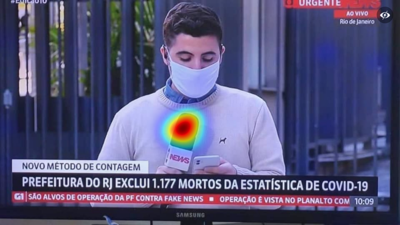

'--------------------------------------------------'

'Rank: 1 Val: 0.0018555358983576298'

'102730_eng'

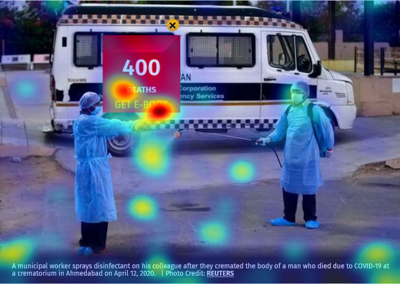

'--------------------------------------------------'

'Rank: 2 Val: 0.001262229518033564'

'102141_2_eng'

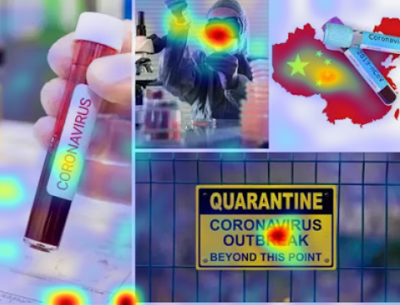

'--------------------------------------------------'

In [22]:
my_obj.show_results(
    search_query3[0], itm=True, image_gradcam_with_itm=image_gradcam_with_itm
)

## Save search results to csv

Convert the dictionary of dictionarys into a dictionary with lists:

In [23]:
outdict = mutils.append_data_to_dict(mydict)
df = mutils.dump_df(outdict)

Check the dataframe:

In [24]:
df.head(10)

,filename,rank politician press conference,politician press conference,rank a world map,a world map,rank a dog,a dog,itm politician press conference,itm_rank politician press conference,itm a world map,itm_rank a world map,itm a dog,itm_rank a dog
0,data/102730_eng.png,1,0.144051,0,0.131088,1,0.100833,0.001856,1,0.004548,1,0.000812,0
1,data/106349S_por.png,0,0.166554,2,0.093529,0,0.108629,0.058296,0,0.000794,2,0.000091,2
2,data/102141_2_eng.png,2,0.113501,1,0.106334,2,0.049040,0.001262,2,0.085763,0,0.000175,1


Write the csv file:

In [25]:
df.to_csv("data/data_out.csv")